In [13]:
import scipy.io
import numpy as np

def load_emnist_byclass(path='emnist-byclass.mat'):
    mat = scipy.io.loadmat(path)
    data = mat['dataset']

    x_train = data['train'][0,0]['images'][0,0]
    y_train = data['train'][0,0]['labels'][0,0].flatten()

    x_test = data['test'][0,0]['images'][0,0]
    y_test = data['test'][0,0]['labels'][0,0].flatten()

    # Reshape images to 28x28 and transpose (order='F')
    x_train = x_train.reshape((-1, 28, 28), order='F').astype(np.uint8)
    x_test = x_test.reshape((-1, 28, 28), order='F').astype(np.uint8)

    # Get label mapping (index to ASCII)
    label_map = data['mapping'][0,0]

    # Find indices for letters only (A-Z or a-z)
    letter_indices = np.where(
        ((label_map[:, 1] >= 65) & (label_map[:, 1] <= 90)) |  # A-Z
        ((label_map[:, 1] >= 97) & (label_map[:, 1] <= 122))   # a-z
    )[0]

    allowed_labels = label_map[letter_indices, 0]

    # Create a remapping dict: old_label -> new_label (0..51)
    new_label_map = {old: i for i, old in enumerate(allowed_labels)}

    # Filter train set to letters only
    train_filter = np.isin(y_train, allowed_labels)
    x_train = x_train[train_filter]
    y_train = y_train[train_filter]
    y_train = np.vectorize(lambda l: new_label_map[l])(y_train)

    # Filter test set to letters only
    test_filter = np.isin(y_test, allowed_labels)
    x_test = x_test[test_filter]
    y_test = y_test[test_filter]
    y_test = np.vectorize(lambda l: new_label_map[l])(y_test)

    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Add channel dimension for CNN: (N, 28, 28, 1)
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)

    return x_train, y_train, x_test, y_test

# Call function to load filtered EMNIST letters
x_train, y_train, x_test, y_test = load_emnist_byclass()
print(f"Train shape: {x_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test shape: {x_test.shape}, Test labels shape: {y_test.shape}")


FileNotFoundError: [Errno 2] No such file or directory: 'emnist-byclass.mat'

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Map numeric labels (0-51) to characters a-z and A-Z
def label_to_char(label):
    if label < 26:
        return chr(label + ord('A'))
    else:
        return chr(label - 26 + ord('a'))

def show_samples(images, labels, num_samples=25):
    plt.figure(figsize=(8, 8))
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(label_to_char(labels[idx]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
show_samples(x_train, y_train)


NameError: name 'x_train' is not defined

In [ ]:
from tensorflow.keras import layers, models

def build_letter_classifier():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(52, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model
model = build_letter_classifier()

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=64
)

Epoch 1/10
5515/5515 [==============================] - 61s 10ms/step - loss: 0.5675 - accuracy: 0.8115 - val_loss: 0.4058 - val_accuracy: 0.8481
Epoch 2/10
5515/5515 [==============================] - 56s 10ms/step - loss: 0.4334 - accuracy: 0.8453 - val_loss: 0.3753 - val_accuracy: 0.8592
Epoch 3/10
5515/5515 [==============================] - 55s 10ms/step - loss: 0.4037 - accuracy: 0.8533 - val_loss: 0.3578 - val_accuracy: 0.8668
Epoch 4/10
5515/5515 [==============================] - 55s 10ms/step - loss: 0.3870 - accuracy: 0.8579 - val_loss: 0.3538 - val_accuracy: 0.8672
Epoch 5/10
5515/5515 [==============================] - 56s 10ms/step - loss: 0.3741 - accuracy: 0.8614 - val_loss: 0.3509 - val_accuracy: 0.8671
Epoch 6/10
5515/5515 [==============================] - 56s 10ms/step - loss: 0.3632 - accuracy: 0.8649 - val_loss: 0.3429 - val_accuracy: 0.8723
Epoch 7/10
5515/5515 [==============================] - 57s 10ms/step - loss: 0.3563 - accuracy: 0.8667 - val_loss: 0.3487 -

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Predict on some test samples
import numpy as np

sample_indices = np.random.choice(len(x_test), 10, replace=False)
sample_images = x_test[sample_indices]
sample_labels = y_test[sample_indices]

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Display predictions vs ground truth
for i, idx in enumerate(sample_indices):
    true_char = label_to_char(sample_labels[i])
    pred_char = label_to_char(predicted_labels[i])
    print(f"Sample {i+1}: True: {true_char} | Predicted: {pred_char}")


1826/1826 - 4s - loss: 0.3355 - accuracy: 0.8724 - 4s/epoch - 2ms/step
Test accuracy: 0.8724
1/1 [==============================] - 0s 133ms/step
Sample 1: True: O | Predicted: O
Sample 2: True: e | Predicted: e
Sample 3: True: t | Predicted: t
Sample 4: True: W | Predicted: w
Sample 5: True: r | Predicted: r
Sample 6: True: e | Predicted: e
Sample 7: True: m | Predicted: M
Sample 8: True: r | Predicted: r
Sample 9: True: P | Predicted: P
Sample 10: True: d | Predicted: d


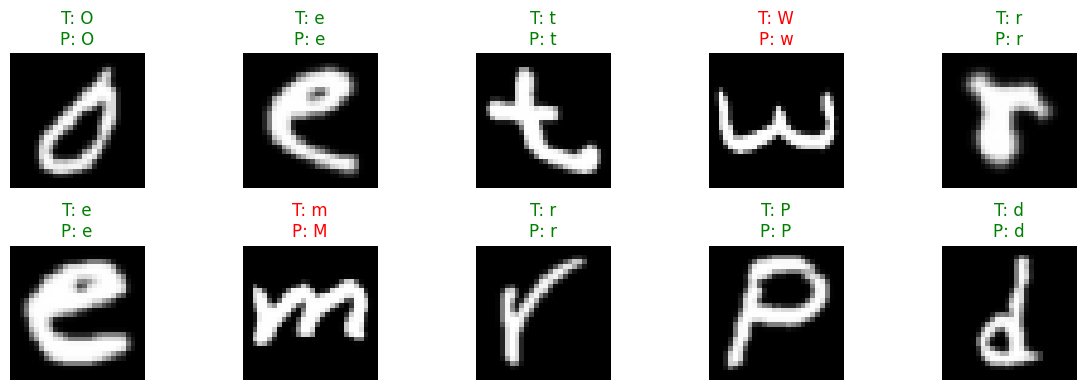

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(images, true_labels, pred_labels):
    plt.figure(figsize=(12, 4))
    for i in range(len(images)):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        title_color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        plt.title(f"T: {label_to_char(true_labels[i])}\nP: {label_to_char(pred_labels[i])}",
                  color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(sample_images, sample_labels, predicted_labels)


In [ ]:
# Save in HDF5 format (recommended for cross-notebook use)
model.save('emnist_letter_classifier.h5')

# Predict on CA2 Dataset

In [48]:
from tensorflow.keras.models import load_model

model = load_model('emnist_letter_classifier.h5')

In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv("C:\School\Year 2\DELE\CA2\emnist-letters-train.csv")

# Check the shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (64828, 785)


,24,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561
0,-2,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,142,142,142
1,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-2,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
4,-1,131,131,131,131,131,131,131,131,200,...,131,131,131,131,131,131,131,131,131,131


In [50]:
# Separate labels and pixel data
labels = data.iloc[:, 0].values
pixels = data.iloc[:, 1:].values

In [51]:
# Reshape and normalize to match training data
images = pixels.reshape(-1, 28, 28, 1).astype('float32')
images = images / 255.0  # Normalize to [0, 1] - SAME AS TRAINING DATA

In [52]:
# First filter out negative labels
valid_mask = labels > 0
filtered_images = images[valid_mask]
filtered_labels = labels[valid_mask]

# Then select only our 16 target classes
selected_numeric = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26]  # A, B, D, E, F, G, I, J, L, N, O, P, Q, T, X, Z
final_mask = np.isin(filtered_labels, selected_numeric)
final_images = filtered_images[final_mask]
final_labels = filtered_labels[final_mask]

In [53]:
# Rotate and flip the images to upright position
from skimage.transform import rotate

# Rotate 90 degrees clockwise (use -90 degrees)
# Then mirror (flip) horizontally with np.fliplr
rotated_images = np.array([
    np.fliplr(rotate(img.squeeze(), -90, resize=False, mode='edge'))
    for img in final_images
])

# Ensure final_images has the correct shape
final_images = rotated_images[..., np.newaxis]

# CRITICAL: Re-normalize to [0, 1] to match training data
# The rotation operation may have changed the pixel range
final_images = final_images.astype('float32')
final_images = (final_images - final_images.min()) / (final_images.max() - final_images.min())

print(f"After processing - pixel range: [{final_images.min():.3f}, {final_images.max():.3f}]")

After processing - pixel range: [0.000, 1.000]


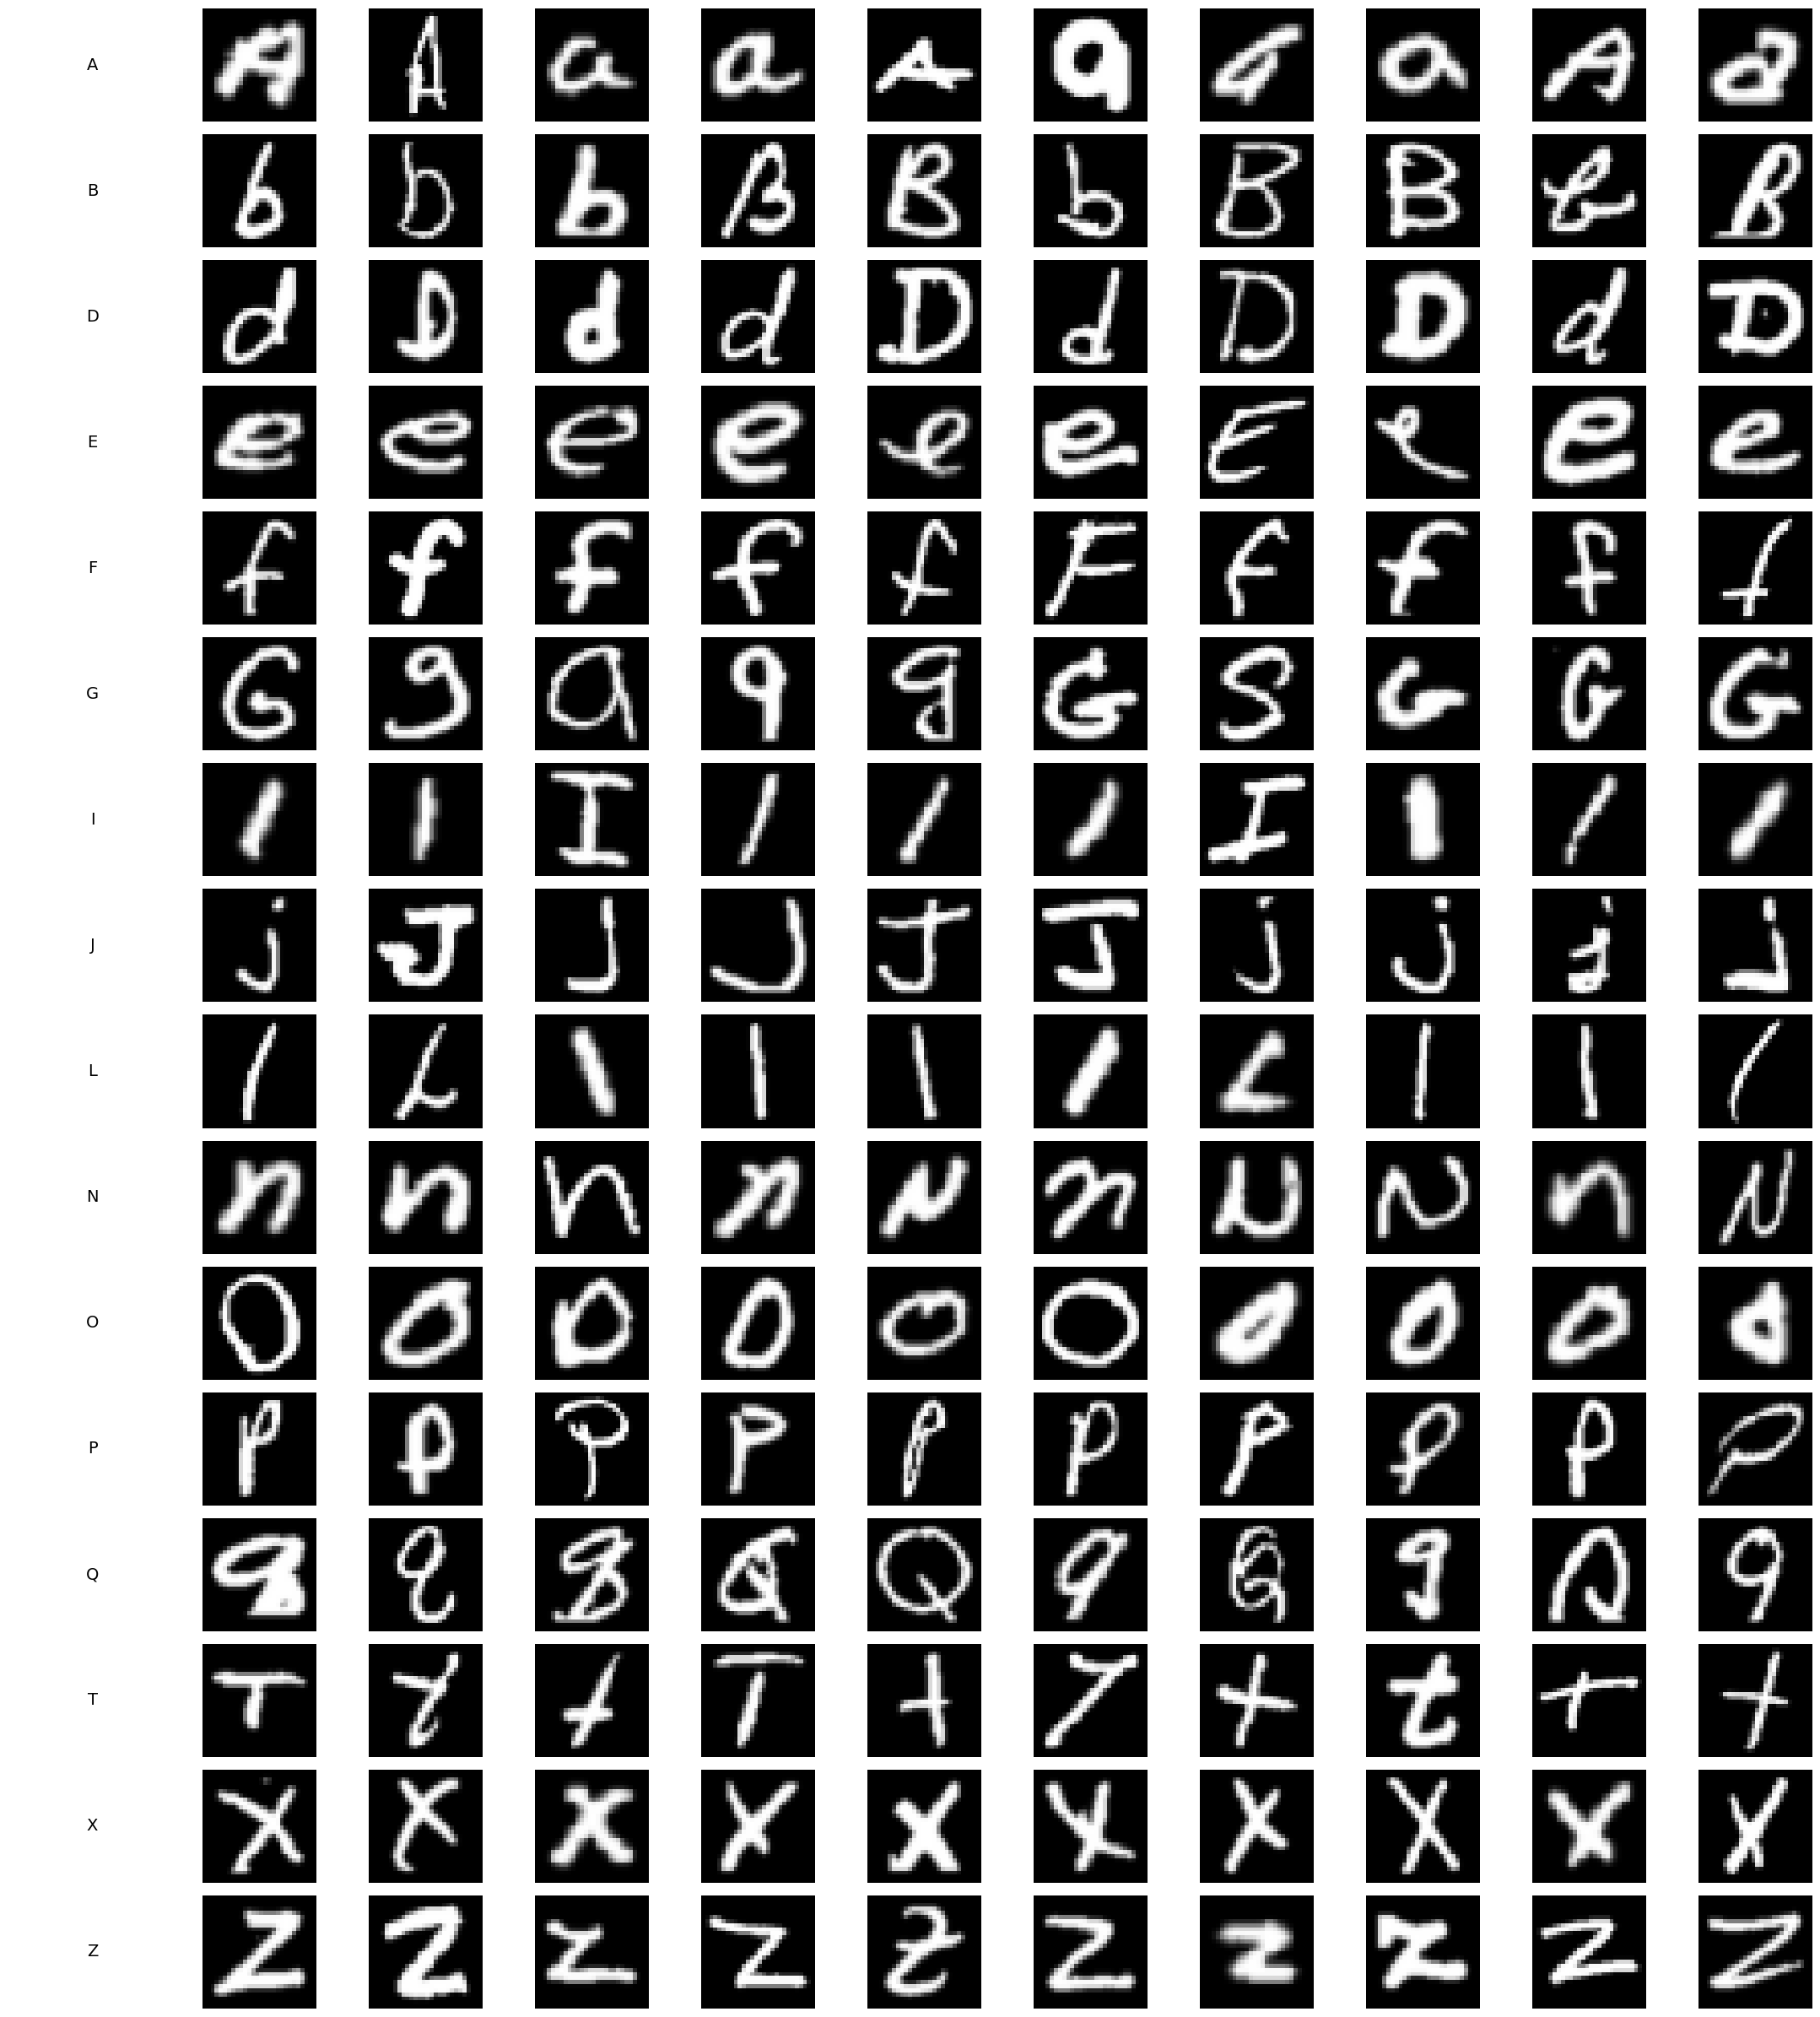

In [54]:
# Get all unique class labels from cleaned data
unique_labels_to_show = np.sort(np.unique(final_labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(final_labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(final_images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [55]:
# Predict letters for all images in final_images using the trained model
pred_probs = model.predict(final_images, batch_size=128, verbose=1)
predicted_labels = np.argmax(pred_probs, axis=1)

# Map numeric labels to characters using the SAME mapping as training
# Training uses: 0-25 for A-Z, 26-51 for a-z
def model_label_to_char(label):
    if label < 26:
        return chr(label + ord('A'))  # 0='A', 1='B', ..., 25='Z'
    else:
        return chr(label - 26 + ord('a'))  # 26='a', 27='b', ..., 51='z'

# Map EMNIST CSV labels to characters (for ground truth)
def csv_label_to_char(label):
    return chr(label + 64)  # EMNIST Letters: 1='A', 2='B', ..., 26='Z'

# Example: show predictions for the first 10 samples
for i in range(10):
    true_char = csv_label_to_char(final_labels[i])
    pred_char = model_label_to_char(predicted_labels[i])
    confidence = np.max(pred_probs[i])
    print(f"Sample {i+1}: True: {true_char} | Predicted: {pred_char} (confidence: {confidence:.3f})")

427/427 [==============================] - 2s 5ms/step
Sample 1: True: O | Predicted: O (confidence: 0.970)
Sample 2: True: N | Predicted: n (confidence: 1.000)
Sample 3: True: A | Predicted: A (confidence: 0.990)
Sample 4: True: J | Predicted: j (confidence: 1.000)
Sample 5: True: E | Predicted: e (confidence: 1.000)
Sample 6: True: G | Predicted: G (confidence: 0.998)
Sample 7: True: G | Predicted: g (confidence: 0.997)
Sample 8: True: F | Predicted: f (confidence: 0.568)
Sample 9: True: O | Predicted: O (confidence: 0.921)
Sample 10: True: F | Predicted: F (confidence: 0.854)
Sample 1: True: O | Predicted: O (confidence: 0.970)
Sample 2: True: N | Predicted: n (confidence: 1.000)
Sample 3: True: A | Predicted: A (confidence: 0.990)
Sample 4: True: J | Predicted: j (confidence: 1.000)
Sample 5: True: E | Predicted: e (confidence: 1.000)
Sample 6: True: G | Predicted: G (confidence: 0.998)
Sample 7: True: G | Predicted: g (confidence: 0.997)
Sample 8: True: F | Predicted: f (confidenc

In [56]:
# Debug: Check the distribution of predictions
unique_preds, counts = np.unique(predicted_labels, return_counts=True)
print("Prediction distribution:")
for pred, count in zip(unique_preds, counts):
    char = model_label_to_char(pred)
    print(f"Label {pred} ('{char}'): {count} samples")

print(f"\nTotal predictions: {len(predicted_labels)}")

# Check if the model is actually predicting the same thing for everything
if len(unique_preds) == 1:
    print(f"WARNING: Model is predicting only one class: {model_label_to_char(unique_preds[0])}")
    print("This suggests there might be an issue with data preprocessing or normalization.")

Prediction distribution:
Label 0 ('A'): 1365 samples
Label 1 ('B'): 1442 samples
Label 2 ('C'): 21 samples
Label 3 ('D'): 1016 samples
Label 4 ('E'): 600 samples
Label 5 ('F'): 3226 samples
Label 6 ('G'): 1357 samples
Label 7 ('H'): 3 samples
Label 8 ('I'): 2989 samples
Label 9 ('J'): 2410 samples
Label 10 ('K'): 3 samples
Label 11 ('L'): 925 samples
Label 12 ('M'): 4 samples
Label 13 ('N'): 1409 samples
Label 14 ('O'): 3417 samples
Label 15 ('P'): 2788 samples
Label 16 ('Q'): 1604 samples
Label 17 ('R'): 3 samples
Label 18 ('S'): 33 samples
Label 19 ('T'): 1263 samples
Label 20 ('U'): 30 samples
Label 21 ('V'): 5 samples
Label 22 ('W'): 1 samples
Label 23 ('X'): 1966 samples
Label 24 ('Y'): 23 samples
Label 25 ('Z'): 1927 samples
Label 26 ('a'): 2122 samples
Label 27 ('b'): 1938 samples
Label 29 ('d'): 2352 samples
Label 30 ('e'): 2836 samples
Label 31 ('f'): 126 samples
Label 32 ('g'): 1841 samples
Label 33 ('h'): 35 samples
Label 34 ('i'): 437 samples
Label 35 ('j'): 873 samples
Lab

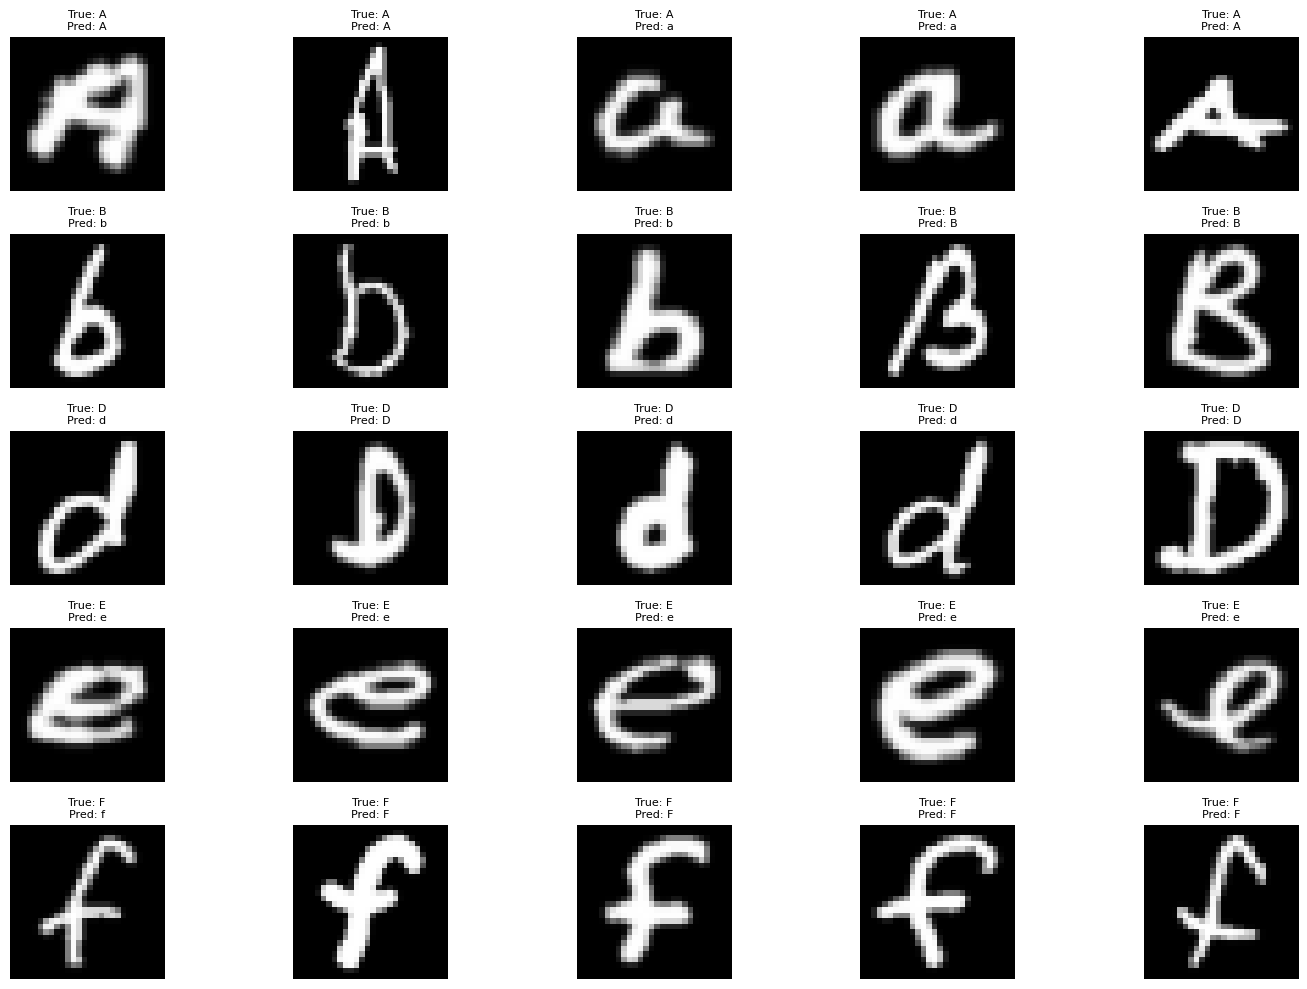

Image pixel range: [0.000, 1.000]
Image shape: (54588, 28, 28, 1)
Image dtype: float32


In [57]:
# Let's visualize some samples to check if the preprocessing is correct
plt.figure(figsize=(15, 10))

# Show first 5 samples of each class
sample_classes = [1, 2, 4, 5, 6]  # A, B, D, E, F
for i, class_label in enumerate(sample_classes):
    class_indices = np.where(final_labels == class_label)[0][:5]
    
    for j, idx in enumerate(class_indices):
        plt.subplot(len(sample_classes), 5, i * 5 + j + 1)
        plt.imshow(final_images[idx].squeeze(), cmap='gray')
        true_char = csv_label_to_char(final_labels[idx])
        pred_char = model_label_to_char(predicted_labels[idx])
        plt.title(f'True: {true_char}\nPred: {pred_char}', fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()

# Let's also check the range of pixel values
print(f"Image pixel range: [{final_images.min():.3f}, {final_images.max():.3f}]")
print(f"Image shape: {final_images.shape}")
print(f"Image dtype: {final_images.dtype}")